# Responsible Data Science Lab 5

In this lab, we will be exploring how data cleaning (or the lack thereof) can impact your analysis. To do so, we will be analyzing data about restaurant health inspections in New York City.

About five years ago, a data analyst uncovered some [concerning trends](https://iquantny.tumblr.com/post/76928412519/think-nyc-restaurant-grading-is-flawed-heres) in the scores that restaurants receive: scores are far more likely to be just *above* a letter grade cutoff than just below the cutoff. This suggests that inspectors are making decisions to avoid giving establishments a bad letter grade, with little regard for the health of customers.

In this lab, we're going to test whether this finding is still true and explore other features by which health inspection scores vary.

In [75]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import display
pd.options.display.max_columns = None

In [76]:
%matplotlib inline
rcParams['figure.figsize'] = [15, 5]

## Step 1: Read in the data

This data was downloaded from [NYC Open Data](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j). There's also more information available on the grading system [here](https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf). 

Take a minute to review the metadata on the [NYC Open Data](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j) page and read the documentation before we dive in. 

In [77]:
# option to download data directly NYC Data Website (RISK: data is updated occassionally so analysis result may vary if data changes)
data_link = "https://www.dropbox.com/s/gurb4h2evm1pm1w/DOHMH_New_York_City_Restaurant_Inspection_Results.csv?dl=1"
inspections = pd.read_csv(data_link)

In [78]:
print(inspections.columns)
print(inspections.dtypes)
inspections.head()

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA'],
      dtype='object')
CAMIS                      int64
DBA                       object
BORO                      object
BUILDING                  object
STREET                    object
ZIPCODE                  float64
PHONE                     object
CUISINE DESCRIPTION       object
INSPECTION DATE           object
ACTION                    object
VIOLATION CODE            object
VIOLATION DESCRIPTION     object
CRITICAL FLAG             object
SCORE                    float64
GRADE                     object
GRADE DATE                object
RECORD DATE               object
INSPECTION TYPE           obj

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,41574968,PHAYUL RESTAURANT,Queens,3765,74 STREET,11372.0,7184241869,Asian,01/28/2020,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,32.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.747173,-73.891484,403.0,25.0,28900.0,4029815.0,4.012850e+09,QN28
1,40965048,UNCLE LOUIE G'S ITALIAN ICES & ICE CREAM,Brooklyn,3138,AVENUE U,11229.0,7183661730,"Ice Cream, Gelato, Yogurt, Ices",07/26/2017,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,11.0,A,07/26/2017,02/23/2021,Cycle Inspection / Initial Inspection,40.602432,-73.933926,315.0,46.0,63200.0,3248250.0,3.088190e+09,BK17
2,41577295,LECHONERA TROPICAL & GRILL,Manhattan,172,EAST 103 STREET,10029.0,2127221344,Latin American (Central and South America),10/04/2019,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,12.0,A,10/04/2019,02/23/2021,Cycle Inspection / Initial Inspection,40.789967,-73.946884,111.0,8.0,16600.0,1082390.0,1.016300e+09,MN33
3,40660193,COOKIE'S LOUNGE,Queens,13208,CROSSBAY BOULEVARD,11417.0,7188355693,American,11/21/2017,Violations were cited in the following area(s).,04H,"Raw, cooked or prepared food is adulterated, c...",Y,9.0,A,11/21/2017,02/23/2021,Cycle Inspection / Initial Inspection,40.676470,-73.843658,410.0,32.0,5800.0,4245349.0,4.113540e+09,QN56
4,40974766,CHIKALICIOUS DESSERT BAR,Manhattan,203,EAST 10 STREET,10003.0,2129959511,Other,06/15/2017,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Y,12.0,A,06/15/2017,02/23/2021,Cycle Inspection / Initial Inspection,40.729591,-73.986369,103.0,2.0,4000.0,1006433.0,1.004520e+09,MN22


In [79]:
# Rename the columns to avoid spaces and make everything lower case
inspections.columns = [x.lower().replace(" ", "_") for x in inspections.columns]
print(inspections.columns)

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'cuisine_description', 'inspection_date', 'action', 'violation_code',
       'violation_description', 'critical_flag', 'score', 'grade',
       'grade_date', 'record_date', 'inspection_type', 'latitude', 'longitude',
       'community_board', 'council_district', 'census_tract', 'bin', 'bbl',
       'nta'],
      dtype='object')


Let's see if we can reproduce the chart in that blog post using current data!

A quick google will get us the cutoffs for the letter grades from a credible source -- the NYC Health Department. According to [this](https://www1.nyc.gov/site/doh/business/food-operators/letter-grading-for-restaurants.page), the cutoffs are 
- A: 0-13
- B: 14-27
- C: 28+

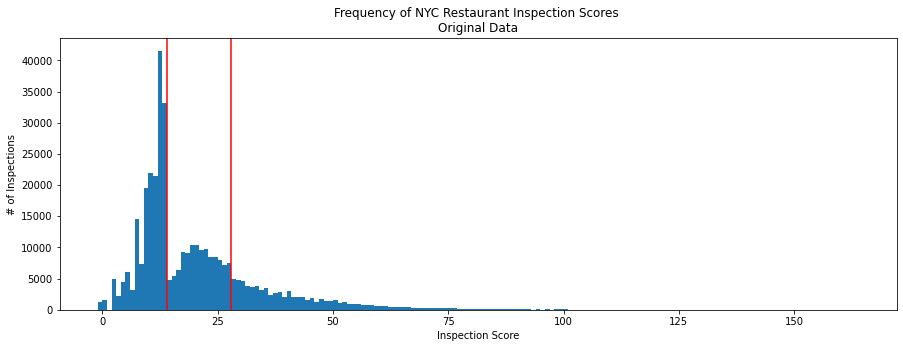

In [80]:
# Let's see if we can reproduce the chart in that blog post right now!
def plot_grades(df, title):
    
    # Plot a histogram
    plt.hist(df['score'], bins=range(int(min(df['score'])), int(max(df['score']))+1) )
    # Add lines to indicate the cutoffs between A and B, then B and C
    plt.axvline(x=14, color="red")
    plt.axvline(x=28, color="red")
    # Add some labels
    plt.ylabel("# of Inspections")
    plt.xlabel("Inspection Score")
    plt.title("Frequency of NYC Restaurant Inspection Scores \n{}".format(title))
    return
    
plot_grades(inspections, "Original Data")


Cool! Are we done? 

What would you say if you saw this chart on the internet?

What would happen if we took this to a reporter or to a public health official? 

**STUDENTS TYPE ANSWER HERE:**
If I saw this chart on the internet, this would be worrying becase it means that inspectors are using discretion when awarding these grades. This is because it is highly unlikely for there to be a large number of restaurants that barely get by with an "A" grade, as indicated by the sharp spike in the graph above.

If we took this to a reporter, it would probably make the news and there might be severe pressure on the public health system to reform the grading system so that it doesn't allow discretion on the part of the health inspector.

## Step 2: Back up and do some profiling

In [81]:
inspections.grade.value_counts()

A    158692
B     26001
C      9907
P      2642
N      2296
Z       600
G         3
Name: grade, dtype: int64

In [82]:
inspections.score.describe()

count    377669.000000
mean         20.114108
std          14.731309
min          -1.000000
25%          11.000000
50%          15.000000
75%          26.000000
max         164.000000
Name: score, dtype: float64

This brings up some questions that suggest we'll have to deal with when cleaning the data: Should there be negative scores? What do letter grades N and Z mean?

In [83]:
# Do some more profiling here! 

# Show some rows with negative values for "inspections.score"
inspections[inspections.score < 0]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
147,50009320,SALT + CHARCOAL,Brooklyn,171,GRAND STREET,11249.0,7185993021,Japanese,02/27/2020,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,-1.0,C,02/27/2020,02/23/2021,Cycle Inspection / Re-inspection,40.714593,-73.961503,301.0,34.0,55300.0,3062619.0,3.023800e+09,BK73
587,50066992,KUNG FU XIAO LONG BAO,Queens,5916,MAIN ST,11355.0,7186612882,Chinese,02/24/2020,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,-1.0,B,02/24/2020,02/23/2021,Cycle Inspection / Re-inspection,40.743672,-73.825654,407.0,20.0,80301.0,4538446.0,4.063810e+09,QN62
822,50074685,SITA THAI,Manhattan,3609A,BROADWAY,10031.0,6469015623,Thai,02/27/2020,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,-1.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.828636,-73.948848,109.0,7.0,23300.0,NaN,1.000000e+00,MN04
986,50082989,DOUBLE DRAGON,Bronx,182,EAST 166 STREET,10456.0,7184102838,Chinese,02/24/2020,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Y,-1.0,B,02/24/2020,02/23/2021,Cycle Inspection / Re-inspection,40.831591,-73.918842,204.0,16.0,18102.0,2002727.0,2.024560e+09,BX14
1732,50090014,MERCHANTS' GATE,Manhattan,1000,8 AVENUE,10019.0,9175750469,American,02/10/2020,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,-1.0,N,NaN,02/23/2021,Pre-permit (Operational) / Initial Inspection,40.766812,-73.982809,104.0,3.0,13900.0,1026054.0,1.010480e+09,MN15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395034,50039497,TOMO JAPANESE CUISINE,Queens,8612A,37TH AVE,11372.0,7182056222,Japanese,02/12/2020,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,-1.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.750145,-73.880374,403.0,21.0,27900.0,4036257.0,4.014740e+09,QN28
395434,50066879,HK CAFE,Queens,4296,MAIN ST,11355.0,7183586488,Chinese,03/09/2020,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,-1.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.752649,-73.826998,407.0,20.0,79702.0,4115453.0,4.051240e+09,QN22
395725,40864264,THE VILLAGE TAVERN,Manhattan,46,BEDFORD STREET,10014.0,2127411935,American,03/03/2020,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,-1.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.730484,-74.004319,102.0,3.0,6700.0,1009910.0,1.005860e+09,MN23
395753,50010946,FOREST BAGELS,Staten Island,1180,FOREST AVENUE,10310.0,7187205827,American,02/18/2020,Violations were cited in the following area(s).,06A,Personal cleanliness inadequate. Outer garment...,Y,-1.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.626494,-74.129426,501.0,49.0,15100.0,5009720.0,5.003540e+09,SI07


In [84]:
# Let's further examine the unique scores and grades for resturants with negative scores
print("Unique grades:",inspections[inspections.score < 0 ].grade.unique())
print("Unique scores:",inspections[inspections.score < 0 ].score.unique())

Unique grades: ['C' 'B' nan 'N' 'A']
Unique scores: [-1.]


Unfortunately data dictionary did not answer this question.

In [85]:
# Lets check restaurants with grades N and Z
inspections[(inspections.grade == 'N') | (inspections.grade == 'Z')]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
96,50101691,NEW YUMMY 88,Brooklyn,130,WILSON AVENUE,11237.0,7188776060,Chinese,03/04/2020,Violations were cited in the following area(s).,02H,Food not cooled by an approved method whereby ...,Y,62.0,N,NaN,02/23/2021,Pre-permit (Operational) / Initial Inspection,40.700750,-73.925836,304.0,34.0,42300.0,3072908.0,3.032080e+09,BK78
297,50098044,LA TERRAZA,Bronx,3035,CROSS BRONX EXPRESSWAY,10465.0,3476211033,Spanish,09/30/2019,Violations were cited in the following area(s).,04J,Appropriately scaled metal stem-type thermomet...,Y,8.0,N,NaN,02/23/2021,Pre-permit (Non-operational) / Initial Inspection,40.822628,-73.818830,210.0,13.0,15800.0,2077159.0,2.054390e+09,BX52
324,50097242,Hook and Reel,Staten Island,1756,FOREST AVENUE,10303.0,9178300159,Seafood,09/18/2019,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,45.0,N,NaN,02/23/2021,Pre-permit (Non-operational) / Initial Inspection,40.624968,-74.147457,501.0,49.0,30301.0,5150289.0,5.014790e+09,SI12
452,50079708,THE MARKET HOTEL EVENT SPACE,Brooklyn,1140,MYRTLE AVENUE,11221.0,9177477164,Other,07/27/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,33.0,N,NaN,02/23/2021,Pre-permit (Operational) / Initial Inspection,40.697026,-73.934722,304.0,34.0,39300.0,3072653.0,3.031930e+09,BK78
486,41059016,BAIRES BAKERY,Queens,9009,ROOSEVELT AVENUE,11372.0,7186724046,"Cakes, Cupcakes, Desserts",01/28/2020,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,53.0,Z,01/28/2020,02/23/2021,Cycle Inspection / Re-inspection,40.748453,-73.876118,403.0,21.0,27500.0,4036371.0,4.014780e+09,QN28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395476,50099156,CAFE MORELOS,Queens,8712,WOODHAVEN BLVD,11421.0,7185789926,Mexican,12/09/2019,Violations were cited in the following area(s).,10H,Proper sanitization not provided for utensil w...,N,46.0,N,NaN,02/23/2021,Pre-permit (Operational) / Initial Inspection,40.693359,-73.852016,409.0,32.0,1800.0,4184264.0,4.089330e+09,QN53
395843,50101560,TAQUERIA BAJA,Brooklyn,830,BROADWAY,11206.0,3474518943,Mexican,03/12/2020,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,21.0,N,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.699224,-73.939282,303.0,36.0,28501.0,3042841.0,3.015790e+09,BK78
395972,50080262,RAJU DRUNK MUNKY,Manhattan,31,CORNELIA STREET,10014.0,9173628927,Indian,01/21/2020,Establishment re-opened by DOHMH,10H,Proper sanitization not provided for utensil w...,N,4.0,Z,01/21/2020,02/23/2021,Cycle Inspection / Reopening Inspection,40.731326,-74.002417,102.0,3.0,6700.0,1078086.0,1.005900e+09,MN23
396204,50102629,PICK A BITE,Brooklyn,8620,4 AVENUE,11209.0,7183335123,Mediterranean,02/21/2020,Violations were cited in the following area(s).,05D,Hand washing facility not provided in or near ...,Y,44.0,N,NaN,02/23/2021,Pre-permit (Operational) / Initial Inspection,40.622586,-74.028447,310.0,43.0,6000.0,3345590.0,3.060440e+09,BK31


The records with grade 'N' and 'Z' look reasonable. So a further look at the data dictionary revealed the following meanings:  
* N = Not Yet Graded  
* A = Grade A  
* B = Grade B  
* C = Grade C  
* Z = Grade Pending  
* P = Grade Pending (issued on re-opening following an initial inspection that resulted in a closure)

In [86]:
# Lets check the zipcodes
inspections.zipcode.value_counts()

10003.0    10214
10019.0     9423
10013.0     8502
10036.0     8464
10002.0     8141
           ...  
10151.0        2
20147.0        1
13746.0        1
11550.0        1
11553.0        1
Name: zipcode, Length: 230, dtype: int64

We know all NYC zipcodes start with "1" so why do we see a zipcode with "20147"?

In [87]:
# Lets checkout the record with zipcode 20147.
inspections[inspections.zipcode == 20147]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
40950,50108022,BEECHERS / SWEET LEAF,0,20408,BASHAN DR,20147.0,7037237264,Other,01/01/1900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02/23/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that the record apparently belongs to boro "0". We also know that NYC has only 5 boroughs - Manhattan, Brooklyn, Queens, Bronx and Staten Island.

In [88]:
# Lets examine the boros
inspections.boro.value_counts()

Manhattan        155933
Brooklyn         100766
Queens            89940
Bronx             36167
Staten Island     13279
0                   246
Name: boro, dtype: int64

Apparently there is a boro with name "0" in our record that suprisingly has 246 records. We have to check those out.

In [89]:
# Let see resturants from our magical boro "0".
inspections[inspections.boro == "0"]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
1068,50005134,KINFOLK,0,94,WYTHE AVE,11249.0,3477992946,American,08/12/2017,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Y,29.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2614,50005059,FREEHOLD,0,45,S 3RD ST,11249.0,7183887591,American,07/30/2018,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,41.0,C,07/30/2018,02/23/2021,Cycle Inspection / Re-inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2631,41669951,YORK COLLEGE CAFETERIA,0,9420,GUY R BREWER BOULEVARD,11451.0,7182622890,American,11/23/2016,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,39.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4717,41685153,RIVERSIDE CAFE,0,NaN,NaN,NaN,2128703043,American,05/09/2017,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,23.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5091,50049804,ASKA,0,47,S 5TH ST,11249.0,9174153265,Scandinavian,09/27/2016,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,16.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388002,41539237,ENERGY FUEL,0,NaN,NaN,NaN,7184563835,American,02/16/2017,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,60.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
390257,41664706,DELICIAS PIZZA AND CHICKEN,0,14120,HOLLY AVE,NaN,7183535070,Pizza,11/17/2016,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Y,13.0,A,11/17/2016,02/23/2021,Cycle Inspection / Re-inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
390309,41664706,DELICIAS PIZZA AND CHICKEN,0,14120,HOLLY AVE,NaN,7183535070,Pizza,11/06/2019,Violations were cited in the following area(s).,06A,Personal cleanliness inadequate. Outer garment...,Y,39.0,NaN,NaN,02/23/2021,Cycle Inspection / Compliance Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391629,41720552,"DUNKIN', BASKIN ROBBINS, POPEYES",0,NaN,NaN,NaN,7182576490,American,12/06/2019,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,5.0,A,12/06/2019,02/23/2021,Cycle Inspection / Re-inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Surprisingly, these records above seem meaningful but we need to investigate more on what boro "0" means in this case since NYC doesn't have a borough called "0". We will come back to this

In [90]:
# What are the worst restaurants?
inspections.loc[inspections.score == max(inspections.score)]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
16516,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Y,164.0,NaN,NaN,02/23/2021,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
58721,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,164.0,NaN,NaN,02/23/2021,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
102849,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,05F,Insufficient or no refrigerated or hot holding...,Y,164.0,NaN,NaN,02/23/2021,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
136386,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,04J,Appropriately scaled metal stem-type thermomet...,Y,164.0,NaN,NaN,02/23/2021,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
192828,50061507,BICKLES 2 GO,Bronx,647,COURTLANDT AVENUE,10451.0,3479634184,"Caribbean (Inc. Cuban, Puerto Rican)",05/08/2019,Establishment Closed by DOHMH. Violations wer...,05D,Hand washing facility not provided in or near ...,Y,164.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.818921,-73.918478,201.0,17.0,6700.0,2001885.0,2.024110e+09,BX34
198471,50061507,BICKLES 2 GO,Bronx,647,COURTLANDT AVENUE,10451.0,3479634184,"Caribbean (Inc. Cuban, Puerto Rican)",05/08/2019,Establishment Closed by DOHMH. Violations wer...,05C,Food contact surface improperly constructed or...,Y,164.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.818921,-73.918478,201.0,17.0,6700.0,2001885.0,2.024110e+09,BX34
205055,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,164.0,NaN,NaN,02/23/2021,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
238553,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,05H,"No facilities available to wash, rinse and san...",Y,164.0,NaN,NaN,02/23/2021,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
277889,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Y,164.0,NaN,NaN,02/23/2021,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
293621,50061507,BICKLES 2 GO,Bronx,647,COURTLANDT AVENUE,10451.0,3479634184,"Caribbean (Inc. Cuban, Puerto Rican)",05/08/2019,Establishment Closed by DOHMH. Violations wer...,04A,Food Protection Certificate not held by superv...,Y,164.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.818921,-73.918478,201.0,17.0,6700.0,2001885.0,2.024110e+09,BX34


In [91]:
# Check out one restaraunt in particular
inspections.loc[(inspections.dba == "DOS TOROS TAQUERIA") & (inspections.street == "4 AVENUE"), ]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
38988,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,06/20/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41º F (smoked fish a...,Y,13.0,A,06/20/2017,02/23/2021,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
111951,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/12/2016,Violations were cited in the following area(s).,15L,Smoke free workplace smoking policy inadequate...,N,NaN,NaN,NaN,02/23/2021,Smoke-Free Air Act / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
132508,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/24/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,6.0,A,05/24/2018,02/23/2021,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
147054,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/09/2019,Violations were cited in the following area(s).,02I,Food prepared from ingredients at ambient temp...,Y,12.0,A,05/09/2019,02/23/2021,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
155197,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/12/2016,Violations were cited in the following area(s).,15I,"""""No Smoking” and/or 'Smoking Permitted” sign ...",N,NaN,NaN,NaN,02/23/2021,Smoke-Free Air Act / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
252533,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/09/2019,Violations were cited in the following area(s).,08B,Covered garbage receptacle not provided or ina...,N,12.0,A,05/09/2019,02/23/2021,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
321207,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/09/2019,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,12.0,A,05/09/2019,02/23/2021,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
352927,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/24/2018,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,6.0,A,05/24/2018,02/23/2021,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
363593,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/12/2016,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,8.0,A,05/12/2016,02/23/2021,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
366608,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/24/2018,Violations were cited in the following area(s).,10I,"Single service item reused, improperly stored,...",N,6.0,A,05/24/2018,02/23/2021,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22


Are there any features that might have a functional dependency, or even redundancy? Let's test it.

In [92]:
def test_dependency(df, col1, col2):
    '''Tests whether there is total redundancy betwen col1 and col2
       by testing the number of unique combinations'''
    unique_1 = len(df[col1].unique())
    unique_2 = len(df[col2].unique())
    unique_combos = len(df[[col1, col2]].drop_duplicates())
    print("Unique values of {}: {}".format(col1, unique_1))
    print("Unique values of {}: {}".format(col2, unique_2))
    print("Unique combos of {} and {}: {}".format(col1, col2, unique_combos))
    return unique_combos == max(unique_1, unique_2)

In [93]:
# Fill in some variables that you think might have functional dependencies
test_dependency(inspections, 'violation_code', 'violation_description')

Unique values of violation_code: 106
Unique values of violation_description: 91
Unique combos of violation_code and violation_description: 106


True

Check dependencies for another pair of features

## Step 3: Find a unique identifier 

In [94]:
# write your code here:
test_dependency(inspections, 'grade_date', 'record_date')

Unique values of grade_date: 1307
Unique values of record_date: 1
Unique combos of grade_date and record_date: 1307


True

In [95]:
test_dependency(inspections, 'grade_date', 'inspection_date')

Unique values of grade_date: 1307
Unique values of inspection_date: 1418
Unique combos of grade_date and inspection_date: 2654


False

In [97]:
test_dependency(inspections, 'cuisine_description', 'grade')

Unique values of cuisine_description: 82
Unique values of grade: 8
Unique combos of cuisine_description and grade: 474


False

Let's start with CAMIS, because the documentation told us that it's a unique identifier for each restaurant. Is it a unique identifier for the dataset?

In [98]:
inspections.shape[0] == inspections.camis.nunique()

False

Wow, we don't even know what "level" the data is at right now. Let's figure out what we *can* use as a unique identifier. 

In [99]:
# First, is this even possible? Are the rows of our data unique?
print("# of duplicates: ", sum(inspections.duplicated()))


# No -- so let's drop these duplicates
inspections = inspections.loc[~inspections.duplicated(), ]

# Now we can search for a unique identifier

# of duplicates:  1


In [100]:
# Test if these variables are a unique identifier
possible_identifier = ['camis', 'inspection_date']
print("# of duplicates: ",sum(inspections.duplicated(possible_identifier)))

# Show some duplicates
inspections.sort_values(possible_identifier, axis=0, inplace=True)
inspections.loc[inspections.duplicated(possible_identifier, keep=False), ].head(10)


# of duplicates:  259373


,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
26321,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,"Cakes, Cupcakes, Desserts",05/11/2018,Violations were cited in the following area(s).,08C,Pesticide use not in accordance with label or ...,N,5.0,A,05/11/2018,02/23/2021,Cycle Inspection / Initial Inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37
174666,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,"Cakes, Cupcakes, Desserts",05/11/2018,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,5.0,A,05/11/2018,02/23/2021,Cycle Inspection / Initial Inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37
9333,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,"Cakes, Cupcakes, Desserts",05/16/2019,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,14.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37
30676,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,"Cakes, Cupcakes, Desserts",05/16/2019,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,14.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37
171214,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,"Cakes, Cupcakes, Desserts",05/16/2019,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Y,14.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37
194120,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,"Cakes, Cupcakes, Desserts",05/18/2017,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,7.0,A,05/18/2017,02/23/2021,Cycle Inspection / Initial Inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37
320761,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,"Cakes, Cupcakes, Desserts",05/18/2017,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,7.0,A,05/18/2017,02/23/2021,Cycle Inspection / Initial Inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37
87274,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,"Cakes, Cupcakes, Desserts",06/11/2019,Violations were cited in the following area(s).,08C,Pesticide use not in accordance with label or ...,N,6.0,A,06/11/2019,02/23/2021,Cycle Inspection / Re-inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37
204223,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,"Cakes, Cupcakes, Desserts",06/11/2019,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,6.0,A,06/11/2019,02/23/2021,Cycle Inspection / Re-inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37
206542,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,"Cakes, Cupcakes, Desserts",06/11/2019,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,6.0,A,06/11/2019,02/23/2021,Cycle Inspection / Re-inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37


Without a domain expert right at hand, we can't resolve some of these duplicates for the purposes of our analysis. Because the total number is small, we can drop them. However, the appropriateness of dropping duplicates will vary from case to case. 

Can anyone think of an example where it would be inappropriate to drop duplicates?

In [101]:
# Drop the duplicates we can't resolve 
unique_id =  ['camis', 'inspection_date', 'violation_code', 'inspection_type']
inspections = inspections.loc[~inspections.duplicated(unique_id), ]
assert sum(inspections.duplicated(unique_id)==0)

That's probably not the level we want to do our analysis at, though: we want one record for every inspection of every restaurant, because that's the level at which grades get assigned. (For example, you don't get a letter grade for not having roaches -- you get a letter grade for the total of all the violations)

Do we really want the data at this level though? 

Let's try to understand more about inspection types.

In [102]:
inspections.inspection_type.value_counts()

Cycle Inspection / Initial Inspection                          230929
Cycle Inspection / Re-inspection                                94481
Pre-permit (Operational) / Initial Inspection                   28018
Pre-permit (Operational) / Re-inspection                        12070
Administrative Miscellaneous / Initial Inspection                7351
Cycle Inspection / Reopening Inspection                          4349
Pre-permit (Non-operational) / Initial Inspection                3287
Administrative Miscellaneous / Re-inspection                     1954
Smoke-Free Air Act / Initial Inspection                          1953
Trans Fat / Initial Inspection                                   1510
Pre-permit (Operational) / Compliance Inspection                 1250
Calorie Posting / Initial Inspection                             1109
Inter-Agency Task Force / Initial Inspection                     1066
Pre-permit (Operational) / Reopening Inspection                  1058
Cycle Inspection / C

In [103]:
# Are all of these inspections similar with respect to the things we care about?
# That is, do all inspeciton types end with a grade that gets posted out on the window?
inspections.loc[inspections.grade.notna(), "inspection_type"].value_counts()

Cycle Inspection / Re-inspection                        91159
Cycle Inspection / Initial Inspection                   82854
Pre-permit (Operational) / Re-inspection                11489
Pre-permit (Operational) / Initial Inspection           10083
Cycle Inspection / Reopening Inspection                  3424
Pre-permit (Operational) / Reopening Inspection           638
Pre-permit (Non-operational) / Initial Inspection         404
Pre-permit (Non-operational) / Re-inspection               40
Inter-Agency Task Force / Initial Inspection               15
Smoke-Free Air Act / Initial Inspection                    14
Pre-permit (Non-operational) / Compliance Inspection        8
Administrative Miscellaneous / Initial Inspection           7
Pre-permit (Operational) / Compliance Inspection            5
Name: inspection_type, dtype: int64

Based on this information, let's make a judgement call: our analysis will only be based on cycle inspections.

We will have to be sure to mention this whenever we are presenting our results.

In [104]:
inspections = inspections.loc[inspections.inspection_type.isin(["Cycle Inspection / Re-inspection", "Cycle Inspection / Initial Inspection"]), ] 

In [105]:
# Let's see if we still need inspection_type to uniquely identify the data
unique_id =  ['camis', 'inspection_date', 'violation_code']
assert sum(inspections.duplicated(unique_id)==0)

Great! Now we know that our data has one record per violation that was discovered at a given restaurant on a given date. 

Should we just keep one record per restaurant per inspection date arbitrarily?

In [106]:
# Test whether we'll lose other information
# if we drop duplicates 
unique_id = ['camis', 'inspection_date']
columns_not_dropped = list(inspections.columns)
columns_not_dropped.remove('violation_code')
columns_not_dropped.remove('violation_description')
print("Unique rows if we drop everything at the violation level: ", len(inspections.loc[~inspections.duplicated(columns_not_dropped), ]))
print("Unique rows if we arbitrarily keep rows that are unique in terms of camis and inspeciton date: ", len(inspections.loc[~inspections.duplicated(unique_id), ]))


Unique rows if we drop everything at the violation level:  191288
Unique rows if we arbitrarily keep rows that are unique in terms of camis and inspeciton date:  111338


We won't actually drop the violations data for now, in case we need it later -- but it's nice to know that we *can* drop it when we're ready to do our analysis. Now we've know how to get one record per cycle inspection per restaurant, AND we know a lot more about our dataset.

Let's check back in with the plot we wanted to make -- if we were to do the analysis after the cleaning we've done so far, has it changed at all from our original attempt?

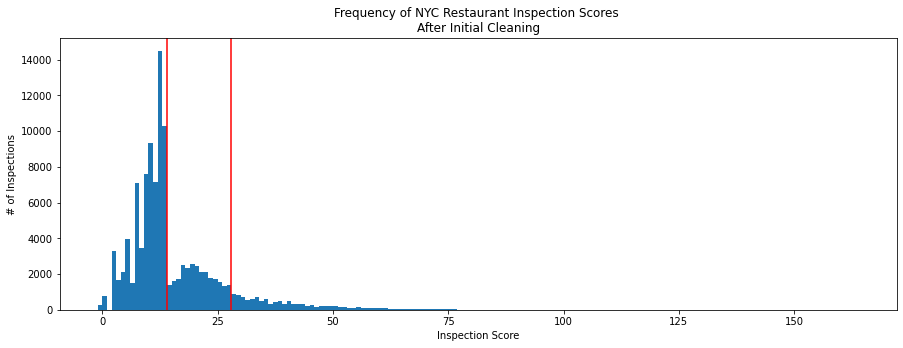

In [107]:
plot_grades(inspections.loc[~inspections.duplicated(unique_id), ], "After Initial Cleaning")

## Step 4: Deep dive into the grades and scores

Recall from earlier that we had grades of N and Z. Can you do some googling and figure out what those are?

Next, let's look at the relationship between grades and scores, and see if it matches what we found on the Department of Health website. As a reminder, the cutoffs should be:

- A: 0-13
- B: 14-27
- C: 28+

In [108]:
inspections.groupby(["grade"]).agg({'score': [np.min,np.max]})

score      
       amin  amax
grade            
A      -1.0  23.0
B      -1.0  32.0
C      -1.0  98.0
N      -1.0  40.0
Z      20.0  61.0

That doesn't look right. Let's look at some actual cases that appear miscoded.

In [109]:
# Cases with a score too high to be assigned an "A" that are marked as an "A"
inspections.sort_values(unique_id, axis=0, inplace=True)
inspections.loc[(inspections.grade=="A") & (inspections.score > 13), ].head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
297461,40399329,ARTE RESTAURANT,Manhattan,21,EAST 9 STREET,10003.0,2124730077,Italian,10/15/2019,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Y,23.0,A,10/15/2019,02/23/2021,Cycle Inspection / Re-inspection,40.732347,-73.994725,102.0,2.0,5900.0,1009240.0,1.005670e+09,MN23
23156,40711301,CHICKEN FESTIVAL,Queens,29-19,DITMARS BOULEVARD,11105.0,7187289696,Chicken,03/14/2018,Violations were cited in the following area(s).,08C,Pesticide use not in accordance with label or ...,N,14.0,A,03/14/2018,02/23/2021,Cycle Inspection / Re-inspection,40.776718,-73.911525,401.0,22.0,11300.0,4017714.0,4.008460e+09,QN72
233216,40711301,CHICKEN FESTIVAL,Queens,29-19,DITMARS BOULEVARD,11105.0,7187289696,Chicken,03/14/2018,Violations were cited in the following area(s).,04A,Food Protection Certificate not held by superv...,Y,14.0,A,03/14/2018,02/23/2021,Cycle Inspection / Re-inspection,40.776718,-73.911525,401.0,22.0,11300.0,4017714.0,4.008460e+09,QN72
251667,40711301,CHICKEN FESTIVAL,Queens,29-19,DITMARS BOULEVARD,11105.0,7187289696,Chicken,03/14/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,14.0,A,03/14/2018,02/23/2021,Cycle Inspection / Re-inspection,40.776718,-73.911525,401.0,22.0,11300.0,4017714.0,4.008460e+09,QN72
198788,41021991,EXTRA VIRGIN,Manhattan,259,WEST 4 STREET,10014.0,2126919359,Mediterranean,05/09/2018,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,21.0,A,05/09/2018,02/23/2021,Cycle Inspection / Re-inspection,40.735287,-74.003258,102.0,3.0,7300.0,1010860.0,1.006128e+09,MN23


In [110]:
# Cases with a negative score
inspections.loc[inspections.score < 0, ]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
5967,40364467,NYAC MAIN DINING ROOM,Manhattan,180,CENTRAL PARK SOUTH,10019.0,2127677000,American,01/07/2020,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,-1.0,C,01/07/2020,02/23/2021,Cycle Inspection / Re-inspection,40.766718,-73.978737,105.0,4.0,13700.0,1023750.0,1.010110e+09,MN17
327464,40364467,NYAC MAIN DINING ROOM,Manhattan,180,CENTRAL PARK SOUTH,10019.0,2127677000,American,01/07/2020,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Y,-1.0,C,01/07/2020,02/23/2021,Cycle Inspection / Re-inspection,40.766718,-73.978737,105.0,4.0,13700.0,1023750.0,1.010110e+09,MN17
359671,40364467,NYAC MAIN DINING ROOM,Manhattan,180,CENTRAL PARK SOUTH,10019.0,2127677000,American,01/07/2020,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,-1.0,C,01/07/2020,02/23/2021,Cycle Inspection / Re-inspection,40.766718,-73.978737,105.0,4.0,13700.0,1023750.0,1.010110e+09,MN17
43579,40365627,JAHN'S RESTAURANT,Queens,81-04,37 AVENUE,11372.0,7186510700,American,03/16/2020,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Y,-1.0,B,03/16/2020,02/23/2021,Cycle Inspection / Re-inspection,40.749653,-73.885074,403.0,21.0,28300.0,4030010.0,4.012920e+09,QN28
51218,40365627,JAHN'S RESTAURANT,Queens,81-04,37 AVENUE,11372.0,7186510700,American,03/16/2020,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,-1.0,B,03/16/2020,02/23/2021,Cycle Inspection / Re-inspection,40.749653,-73.885074,403.0,21.0,28300.0,4030010.0,4.012920e+09,QN28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15740,50095290,SUBCONSCIOUS,Manhattan,1213,AMSTERDAM AVENUE,10027.0,2128642720,Sandwiches/Salads/Mixed Buffet,01/07/2020,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,-1.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.809103,-73.959371,109.0,7.0,20701.0,1059514.0,1.019620e+09,MN09
124966,50095290,SUBCONSCIOUS,Manhattan,1213,AMSTERDAM AVENUE,10027.0,2128642720,Sandwiches/Salads/Mixed Buffet,01/07/2020,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,-1.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.809103,-73.959371,109.0,7.0,20701.0,1059514.0,1.019620e+09,MN09
170837,50095290,SUBCONSCIOUS,Manhattan,1213,AMSTERDAM AVENUE,10027.0,2128642720,Sandwiches/Salads/Mixed Buffet,01/07/2020,Violations were cited in the following area(s).,02H,Food not cooled by an approved method whereby ...,Y,-1.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.809103,-73.959371,109.0,7.0,20701.0,1059514.0,1.019620e+09,MN09
287267,50095290,SUBCONSCIOUS,Manhattan,1213,AMSTERDAM AVENUE,10027.0,2128642720,Sandwiches/Salads/Mixed Buffet,01/07/2020,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,-1.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,40.809103,-73.959371,109.0,7.0,20701.0,1059514.0,1.019620e+09,MN09


It's time to make a judgement call. Here are the options:

1. Trust the grades in the dataset, and ignore the inconsistent scores. 
2. Trust the scores in the dataset, and resassign new grades based on the scores. 
3. Trust the list of violations, and try to reconstruct the grades and the scores.
4. Trust nothing, and drop all the cases with inconsistencies. 

Which would you do? What additional information would you want before deciding?

**STUDENTS TYPE ANSWER HERE:**
I would trust nothing, and drop the inconsistencies. Before deciding, I would want to know what percentage of the data is categorized as inconsistent.


In [ ]:
# If we're not going to use the violations, we can go ahead and collapse our data to the restaurant-inspection level
inspections = inspections.loc[~inspections.duplicated(unique_id), ]

In [ ]:
# Drop cases with impossible scores (-1)
inspections = inspections.loc[inspections.score > 0, ]

In [ ]:
# Count miscoded cases
print("Miscoded As: ", len(inspections.loc[(inspections.grade=="A") & (inspections.score > 13), ]))
print("Miscoded Bs: ", len(inspections.loc[(inspections.grade=="B") & ((inspections.score < 14) | (inspections.score > 27))]))
print("Miscoded Cs: ", len(inspections.loc[(inspections.grade=="C") & (inspections.score < 28), ]))
print("Total Graded Cases: ", len(inspections.loc[inspections.grade.isin(["A", "B", "C"])]))

Miscoded As:  6
Miscoded Bs:  11
Miscoded Cs:  3
Total Graded Cases:  72830


In [ ]:
# Drop miscoded cases
inspections = inspections.loc[~((inspections.grade=="A") & (inspections.score > 13)), ]
inspections = inspections.loc[~((inspections.grade=="B") & (inspections.score < 14)), ]
inspections = inspections.loc[~((inspections.grade=="B") & (inspections.score > 27)), ]
inspections = inspections.loc[~((inspections.grade=="C") & (inspections.score < 28)), ]

Now, we should check out cases with missing grades. 

In [ ]:
print("Cases with missing grades: ", len(inspections.loc[inspections.grade.isna(), ]))
print("Score distribution for cases with missing grades: ", inspections.loc[inspections.grade.isna(), ].score.describe())

Cases with missing grades:  37443
Score distribution for cases with missing grades:  count    37443.000000
mean        23.930294
std         12.932523
min          2.000000
25%         16.000000
50%         21.000000
75%         29.000000
max        164.000000
Name: score, dtype: float64


We aren't actually using the grades for our analysis, and the missingness has meaning, so we can leave these missing values as-is. Sometimes missing data *shouldn't* be imputed!

Time to revisit our plot again.

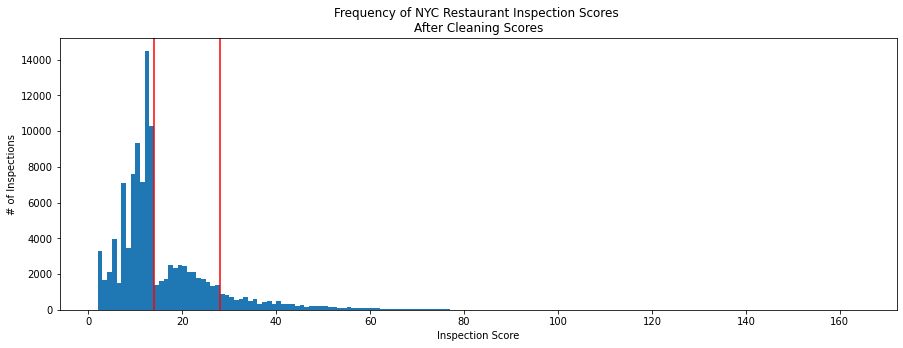

In [ ]:
plot_grades(inspections.loc[~inspections.duplicated(unique_id), ], "After Cleaning Scores")

Now, our original question is whether this tendency to bump up borderline cases has gotten better or worse over time. We can analyze that using the inspection_date column.... but first we have to clean it.

In [ ]:
# Check the current type of the date column
print("Data type: ", inspections.inspection_date.dtype)
inspections.inspection_date.head(10)

Data type:  object


26321     05/11/2018
9333      05/16/2019
194120    05/18/2017
87274     06/11/2019
52719     10/21/2019
349776    11/04/2019
54381     03/04/2019
71809     03/13/2018
51727     04/30/2016
249844    06/26/2017
Name: inspection_date, dtype: object

In [ ]:
inspections.inspection_date = pd.to_datetime(inspections.inspection_date)
inspections.inspection_date.head(10)

26321    2018-05-11
9333     2019-05-16
194120   2017-05-18
87274    2019-06-11
52719    2019-10-21
349776   2019-11-04
54381    2019-03-04
71809    2018-03-13
51727    2016-04-30
249844   2017-06-26
Name: inspection_date, dtype: datetime64[ns]

In [ ]:
inspections['year'] = inspections.inspection_date.dt.year
inspections.year.value_counts()

2019    40419
2018    33990
2017    22491
2020     8032
2016     5289
2015       45
2014       12
2013        7
2012        7
2011        4
Name: year, dtype: int64

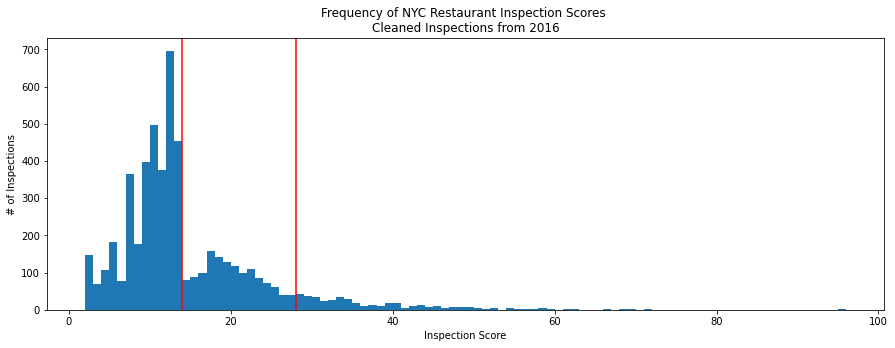

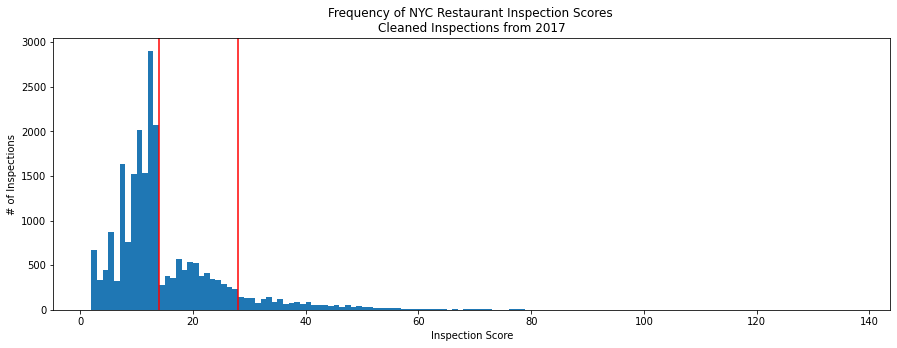

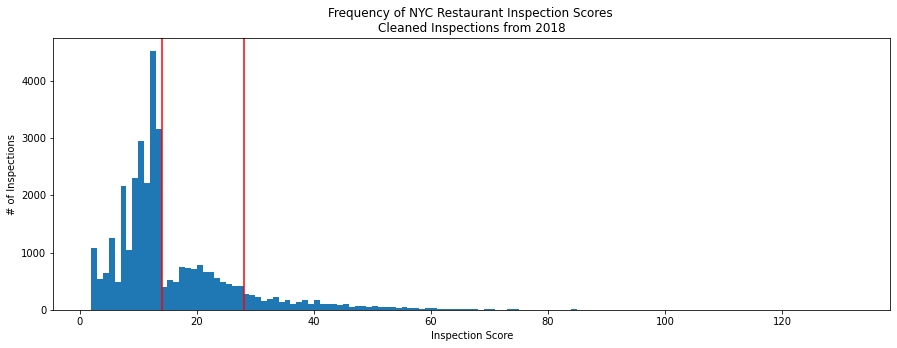

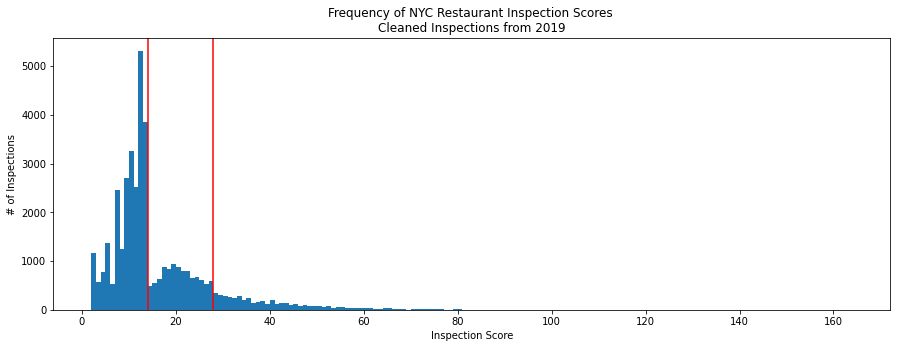

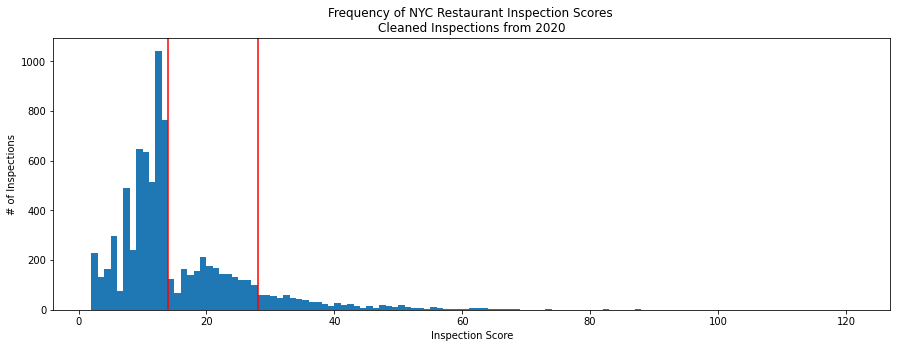

In [ ]:
for year in range(2016, 2021):
    plot_grades(inspections.loc[inspections.year==year, ], "Cleaned Inspections from {}".format(year))
    plt.show()

## Step 5: Analysis by borough 

Let's compare the distribution of scores by borough. First, we should check to see if borough was coded correctly. We know that there should be a functional dependency between zipcode and borough, and we can test for violations of that dependency. 

Note that this approach means that we're trusting the zip code column more than the borough column. 

In [ ]:
test_dependency(inspections, 'zipcode', 'boro')

Unique values of zipcode: 225
Unique values of boro: 6
Unique combos of zipcode and boro: 235


False

To resolve the violations, we should check for cases where one zipcode corresponds to multiple boroughs. (The relationship between zipcodes and boroughs should be many to one.)

In [ ]:
zip_boro_crosswalk = inspections[['zipcode', 'boro']].drop_duplicates()
zip_boro_crosswalk.sort_values('zipcode', inplace=True)
zip_boro_crosswalk.loc[zip_boro_crosswalk.duplicated('zipcode', keep=False), ]

,zipcode,boro
153454,10168.0,0
28846,10168.0,Manhattan
90317,11249.0,Brooklyn
58637,11249.0,0
341718,11370.0,Queens
133187,11370.0,Bronx
22441,11371.0,Queens
31941,11371.0,Manhattan
318418,11430.0,Manhattan
73793,11430.0,Queens


The cases miscoded as zero are an easy fix. 

The rest of the cases are missing zip codes. Since we're doing our analysis by borough and not by zip code, that's fine for our purposes.

In [ ]:
# Lets check the zipcodes of records with 'boro' == 0
inspections[inspections.boro == '0'].zipcode.unique()

array([10285.,    nan, 11451., 11249., 10168., 10166., 30339.])

Using the zipcodes we can find the correct borough by manual inspection using the [link](https://www.unitedstateszipcodes.org/ny/#zips-list).    
NB: "New York County" == "Manhattan"

In [ ]:
# Recode miscoded zip codes based on data from https://www.unitedstateszipcodes.org/ny/#zips-list
inspections.loc[inspections.zipcode == 10166, "boro"] = "Manhattan"
inspections.loc[inspections.zipcode == 10168, "boro"] = "Manhattan"
inspections.loc[inspections.zipcode == 10285, "boro"] = "Manhattan"
inspections.loc[inspections.zipcode == 11249, "boro"] = "Brooklyn"
inspections.loc[inspections.zipcode == 11451, "boro"] = "Queens"

# Re-make the crosswalk now that we've fixed the data
zip_boro_crosswalk = inspections[['zipcode', 'boro']].drop_duplicates()

But just to be on the safe side, let's check against a ground truth source: a list of zip codes by borough.  

We got the zipcode and borough data from this [site](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php)  

NB: Site is missing some zipcodes that are outside NYC.

In [ ]:
nyc_zipcode_path = "https://raw.githubusercontent.com/DataResponsibly/rds/main/assets/zip_borough.csv"
true_zip_boro_crosswalk = pd.read_csv(nyc_zipcode_path)
true_zip_boro_crosswalk = true_zip_boro_crosswalk.replace("Staten", "Staten Island")
true_zip_boro_crosswalk.head()

,zip,borough
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan
3,10004,Manhattan
4,10005,Manhattan


In [ ]:
true_zip_boro_crosswalk[true_zip_boro_crosswalk.borough == 'Manhattan']

,zip,borough
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan
3,10004,Manhattan
4,10005,Manhattan
...,...,...
91,10278,Manhattan
92,10279,Manhattan
93,10280,Manhattan
94,10281,Manhattan


In [ ]:
len(true_zip_boro_crosswalk.zip.unique())

240

In [ ]:
# Compare the two crosswalks
merged_crosswalk = zip_boro_crosswalk.merge(true_zip_boro_crosswalk, how="left", left_on="zipcode", right_on="zip")
merged_crosswalk.loc[(merged_crosswalk.boro != merged_crosswalk.borough) & merged_crosswalk.zipcode.notna(), ]

,zipcode,boro,zip,borough
7,10065.0,Manhattan,NaN,NaN
43,10075.0,Manhattan,NaN,NaN
56,11001.0,Queens,NaN,NaN
145,11040.0,Queens,NaN,NaN
193,10285.0,Manhattan,NaN,NaN
204,10000.0,Manhattan,NaN,NaN
208,11005.0,Queens,NaN,NaN
210,11451.0,Queens,NaN,NaN
211,10179.0,Manhattan,NaN,NaN
215,11430.0,Manhattan,11430.0,Queens


There's another that we didn't catch simply by testing for violations! Good thing we checked against a ground truth source.

The other zip code (30339) appear fake. We should check the address or coordinates of those restaurants to confirm that they are marked as being in the right borough.

In [ ]:
# List the cases with fake zip code so that we can check the borough by hand
inspections[inspections.zipcode == 30339]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,year
198718,50064306,DYLAN'S CANDY BAR,0,2849,paces ferry rd,30339.0,7187514247,Other,2019-05-16,Violations were cited in the following area(s).,04A,Food Protection Certificate not held by superv...,Y,12.0,A,05/16/2019,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
222674,50064306,DYLAN'S CANDY BAR,0,2849,paces ferry rd,30339.0,7187514247,Other,2018-06-07,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Y,10.0,A,06/07/2018,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018


In [ ]:
# Filter out all records excluding those with fake zipcode
inspections = inspections[inspections.zipcode != 30339].copy()

In [ ]:
# Confirm we don't have records with the fake zipcode
inspections[inspections.zipcode == 30339]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,year


So what do we do with other records were boro is '0' and no zipcode was provided?

In [ ]:
# Let's take a look
inspections[inspections.boro == '0']

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,year
283447,41406318,EL NUEVO BOHIO TROPICAL,0,NaN,NaN,NaN,7184094442,Latin American (Central and South America),2018-02-05,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,6.0,A,02/05/2018,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
89929,41406318,EL NUEVO BOHIO TROPICAL,0,NaN,NaN,NaN,7184094442,Latin American (Central and South America),2019-02-15,Violations were cited in the following area(s).,05B,"Harmful, noxious gas or vapor detected. CO ~1 ...",Y,13.0,A,02/15/2019,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
205319,41406318,EL NUEVO BOHIO TROPICAL,0,NaN,NaN,NaN,7184094442,Latin American (Central and South America),2020-02-18,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,7.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
42157,41539237,ENERGY FUEL,0,NaN,NaN,NaN,7184563835,American,2017-02-16,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,60.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
168970,41539237,ENERGY FUEL,0,NaN,NaN,NaN,7184563835,American,2017-03-07,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,9.0,A,03/07/2017,02/23/2021,Cycle Inspection / Re-inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
232125,41539237,ENERGY FUEL,0,NaN,NaN,NaN,7184563835,American,2019-05-10,Violations were cited in the following area(s).,06E,"Sanitized equipment or utensil, including in-u...",Y,13.0,A,05/10/2019,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
215878,41539237,ENERGY FUEL,0,NaN,NaN,NaN,7184563835,American,2018-05-12,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,7.0,A,05/12/2018,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
66763,41539237,ENERGY FUEL,0,NaN,NaN,NaN,7184563835,American,2017-08-15,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,15.0,NaN,NaN,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
49660,41539237,ENERGY FUEL,0,NaN,NaN,NaN,7184563835,American,2017-10-14,Violations were cited in the following area(s).,02G,Cold food item held above 41º F (smoked fish a...,Y,18.0,B,10/14/2017,02/23/2021,Cycle Inspection / Re-inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
284785,41633655,WOODSIDE CAFE RESTAURANT,0,NaN,NaN,NaN,3476423445,Indian,2018-01-17,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,8.0,A,01/17/2018,02/23/2021,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018


According to the data dictionary: "There may be discrepancies between zip code and listed boro due to differences in an establishment's mailing address and physical location". And since we can't resolve this we will need to decide how to handle it in the next steps.

In [ ]:
# Lets look at distribution of boros
inspections['boro'].value_counts()

Manhattan        43638
Brooklyn         27378
Queens           24977
Bronx            10442
Staten Island     3822
0                   37
Name: boro, dtype: int64

In [ ]:
# Comparing percentages
print("Percentage of remaining records with where boro is '0':",inspections['boro'].value_counts()['0']/len(inspections))
print("Percentage of records where boro is Manhattan:",inspections['boro'].value_counts()['Manhattan']/len(inspections))

Percentage of remaining records with where boro is '0': 0.00033546702449815946
Percentage of records where boro is Manhattan: 0.3956516220283968


Since there are no other ways of finding out the actual boros of the remaining 37 records with boros = '0'. We can either drop the records or impute.

Since we don't want to drop records we can impute the missing boros with "Manhattan" since Manhattan represents about 40% of the entire boroughs in the data set

In [ ]:
# Recode the remaining boros with "0" to Manhattan

inspections['boro'].replace("0","Manhattan", inplace=True)

Let's do one final check to make sure that there are no more zeros.

In [ ]:
(inspections.boro != "0").all()

True

In [ ]:
assert (inspections.boro != "0").all()

Now, we're ready to analyze scores by borough!

In [ ]:
inspections.boro.unique()

array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object)

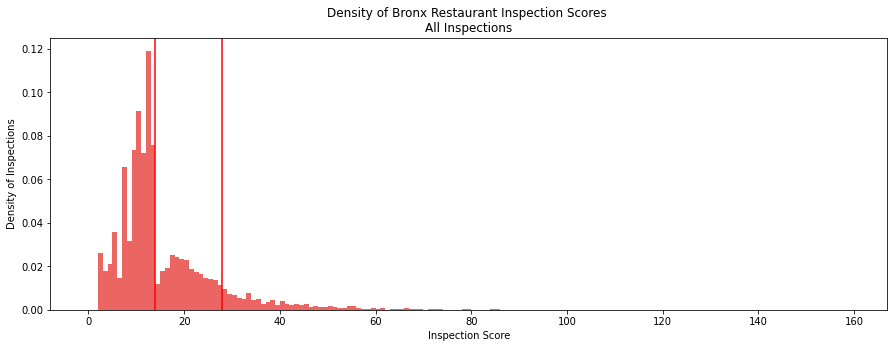

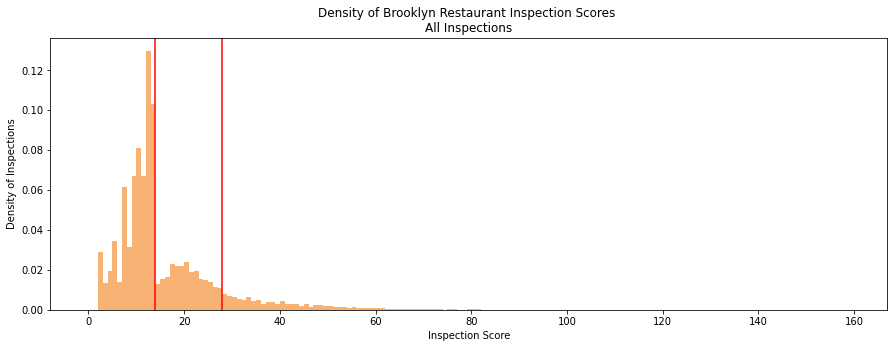

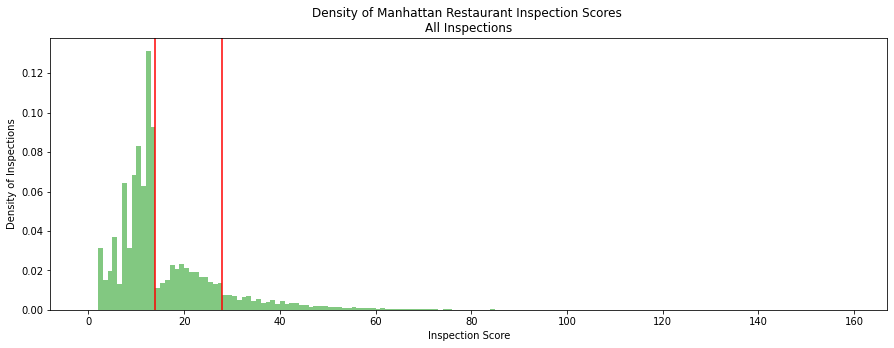

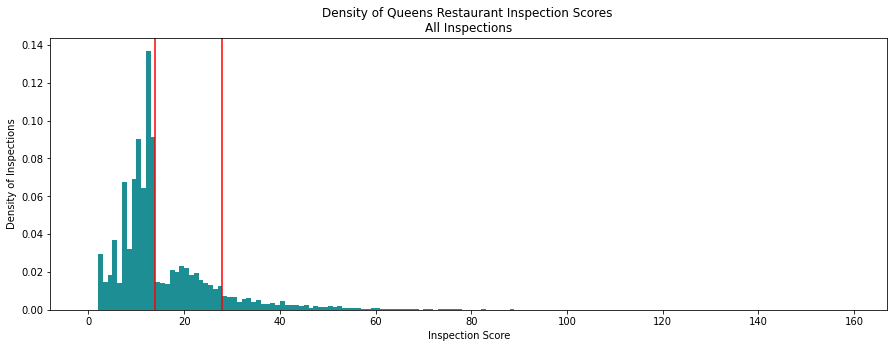

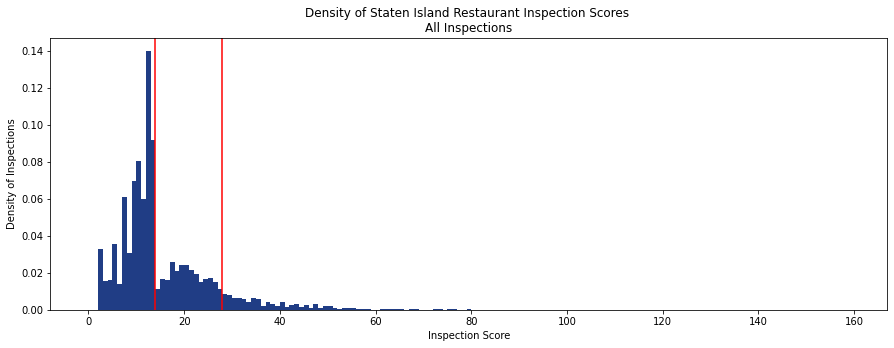

In [ ]:
def scores_by_borough(df, title):
    # Plot a histogram for each borough
    boroughs = df.boro.unique()
    colors = ['#EB6662', '#F7B172', "#82C881", "#1D8F94", "#203D85"]
    for i in range(len(boroughs)):
        borough_df = df.loc[df.boro == boroughs[i], ]
        plt.hist(borough_df['score'], density=True, bins=range(0, 160), color=colors[i], label = boroughs[i])
        # Add lines to indicate the cutoffs between A and B, then B and C
        plt.axvline(x=14, color="red")
        plt.axvline(x=28, color="red")
        # Add some labels
        plt.ylabel("Density of Inspections")
        plt.xlabel("Inspection Score")
        plt.title("Density of {} Restaurant Inspection Scores \n{}".format(boroughs[i], title))
        plt.show()
    return
    
scores_by_borough(inspections, "All Inspections")


## Step 6: Analysis of Starbucks

Our analysis above was very general -- each borough is a big and diverse place! (Okay, maybe not Staten Island.)

Instead, we can try looking at chains that have locations in all boroughs; that way, we know that borough is the only thing that varies in the sample. Let's use Starbucks as an example.

In [ ]:
# Mark Starbucks
inspections['starbucks'] = inspections.dba=="STARBUCKS"
print("# of Starbucks: \n", inspections.groupby(['boro']).starbucks.sum())

# of Starbucks: 
 boro
Bronx             19
Brooklyn         129
Manhattan        678
Queens           132
Staten Island     24
Name: starbucks, dtype: int64


In [ ]:
inspections.dba.isna().sum()

0

In [ ]:
inspections.loc[inspections.dba.str.startswith("STAR"), "dba"]

7313                            STARBUCKS
243358                          STARBUCKS
247030                          STARBUCKS
107962                          STARBUCKS
98667                           STARBUCKS
                       ...               
4791                            STARBUCKS
40561     STARBUCKS COFFEE COMPANY #29854
54090           STAR OF SIAM THAI KITCHEN
314290               STAR MOUNTAIN COFFEE
366932                     STARBUCKS TAXI
Name: dba, Length: 1284, dtype: object

In [ ]:
# Let's see if we missed anything
inspections.loc[inspections.dba.str.startswith("STAR"), "dba"].value_counts().sort_index()

STAR 99C PIZZA                           8
STAR BILLIARDS                           3
STAR CAFE                                2
STAR CAFE & BAKERY                       3
STAR KABAB & CHINESE RESTAURANT         13
STAR LITE DELI                          11
STAR MOUNTAIN COFFEE                     7
STAR OF SIAM THAI KITCHEN                1
STAR ON 18TH DINER CAFE                  8
STAR PARK                                2
STAR RESTAURANT                          6
STAR'S CAFE (WESTIN HOTEL)               5
STARBUCKS                              982
STARBUCKS # 24485                        3
STARBUCKS #48990                         2
STARBUCKS #50611                         2
STARBUCKS #54446                         1
STARBUCKS #7860                          4
STARBUCKS #847                           5
STARBUCKS (Fordham University)           2
STARBUCKS (Store #50483)                 2
STARBUCKS 379 DEKALB(DESIGN CENTER)      1
STARBUCKS COFFE #55085                   1
STARBUCKS C

In [ ]:
inspections['starbucks'] = inspections.dba.str.startswith("STARBUCKS") & (~inspections.dba.str.contains("TAXI"))
print("# of Starbucks: \n", inspections.groupby(['boro']).starbucks.sum())

# of Starbucks: 
 boro
Bronx             28
Brooklyn         163
Manhattan        819
Queens           152
Staten Island     30
Name: starbucks, dtype: int64


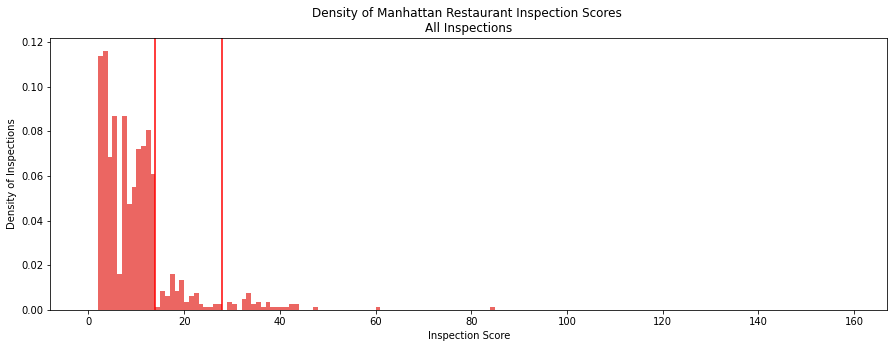

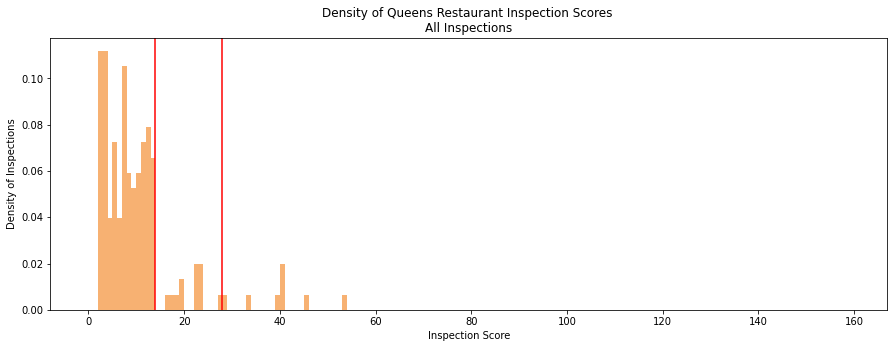

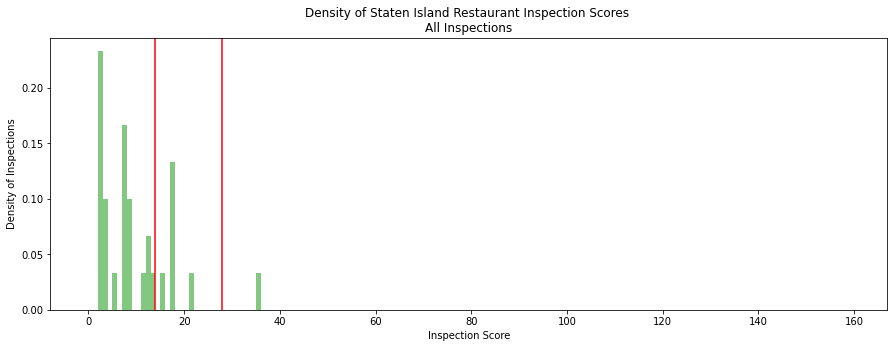

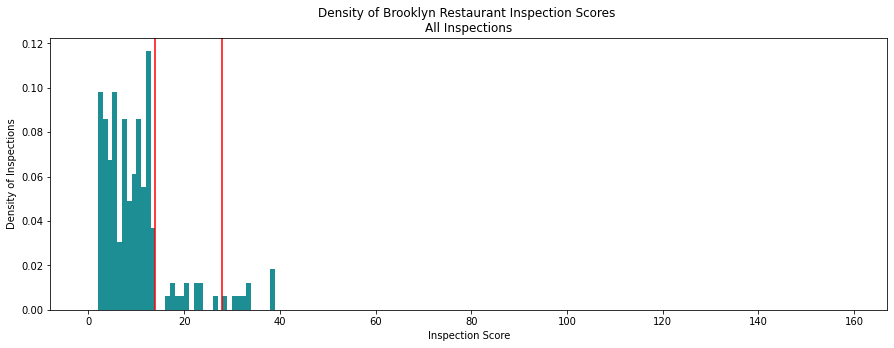

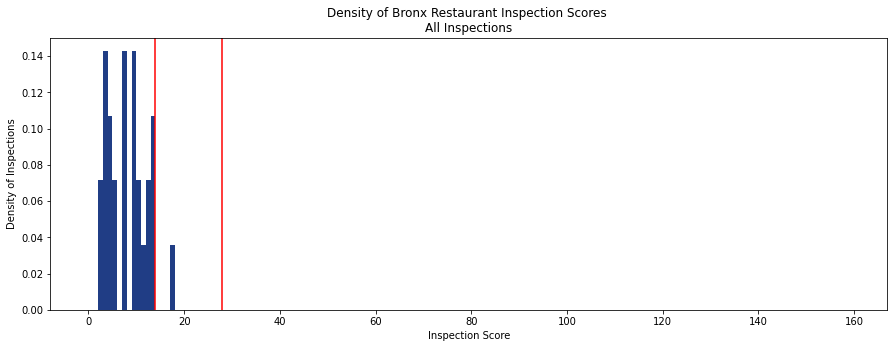

In [ ]:
scores_by_borough(inspections.loc[inspections.starbucks, ], "All Inspections")